# TM10007: Machine learning
## Week 2, lecture 2: What is a good feature?
#### Author: Hakim C. Achterberg

In this exercise, you will have a look at feature handling.


In [0]:
!pip install sklearn numpy matplotlib

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm

In [0]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

For illustration of feature scaling, we are considering a dataset with the height and weight of subjects:

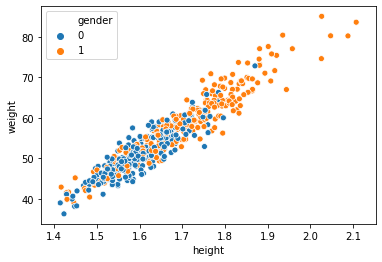

In [0]:
# Create a dataset
gender = np.random.randint(0, 2, 500)
height = (8 + 5 * gender) * np.random.randn(500) + 160 + 10 * gender
bmi = np.random.randn(500) * 1 + 20 
weight = ((height / 100) ** 2) * bmi

dataframe = pd.DataFrame({
    'height': height / 100,
    'weight': weight,
    'bmi': bmi,
    'gender': gender,
})


seaborn.scatterplot(x='height', y='weight', hue='gender', data=dataframe)


## Attempt at classification using a kNN

Again we will turn to our trusty kNN and see how it can handle the following problem.

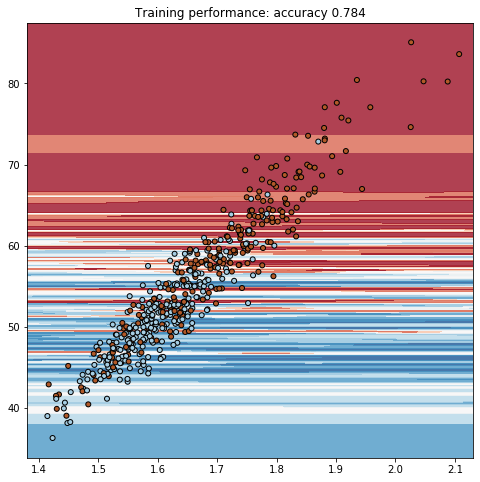

In [0]:
X = np.array(dataframe[['height', 'weight']])
y = np.array(dataframe['gender'])
    
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X, y)

# Test the classifier on the training data and plot
score_train = clf_knn.score(X, y)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Training performance: accuracy {score_train}")
colorplot(clf_knn, ax, X[:, 0], X[:, 1], h=1000)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=y,
           s=25, edgecolor='k', cmap=plt.cm.Paired)


You can see the classification boundaries being all weird, basically the weight completely dominates the classification and the height has very little influence. This is because the features are not scaled properly.

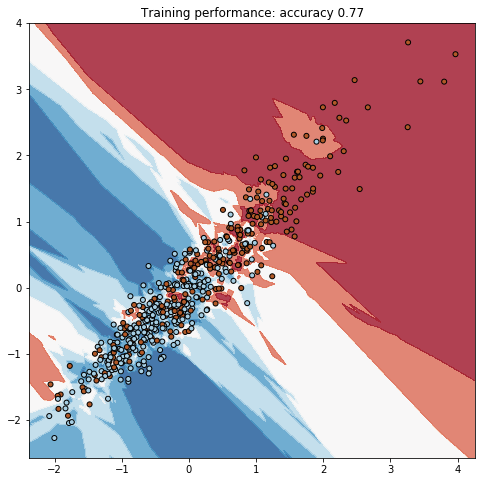

In [0]:
# Scale the dataset
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


clf_knn = neighbors.KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_scaled, y)

# Test the classifier on the training data and plot
score_train = clf_knn.score(X_scaled, y)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Training performance: accuracy {score_train}")
colorplot(clf_knn, ax, X_scaled[:, 0],X_scaled[:, 1], h=1000)
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='o', c=y,
           s=25, edgecolor='k', cmap=plt.cm.Paired)

### Exercise: Different scaling method

This is the most common scaling method. But there are other methods, such as the min-max scaling using the `sklearn.preprocessing.MinMaxScaler` or `sklearn.preprocessing.RobustScaler`. Try adapt the above example and look at the difference. When would you use min-max and when would you use standard scaling?

# Feature selection/extraction

When we have very high dimensional data, we can use feature selection or extraction to make the problem easier for a classifier.

In [0]:
X2, y2 = ds.make_classification(n_samples=250, n_features=50, n_informative=5,
                              n_redundant=20, n_repeated=10, n_classes=2,
                              n_clusters_per_class=2, class_sep=0.7, random_state=0)

Use recursive feature elimination to find a good amount of features. This implementation use the importance of features in a classifier to eliminate features. 

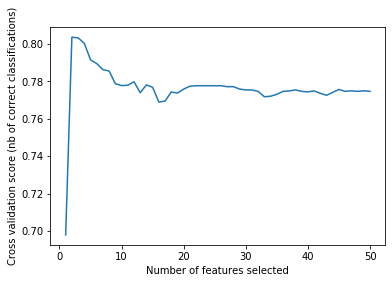

In [0]:
# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X2, y2)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


## PCA

Principal component analysis allows you to rotate the data so that the first component captures to most variance, and the second the second most, etc.

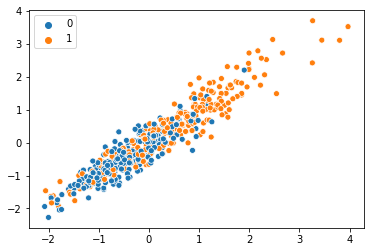

In [0]:
seaborn.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y)

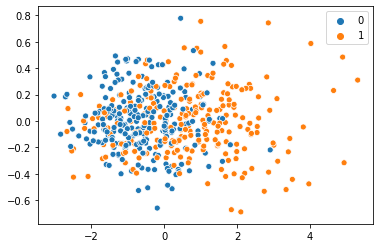

In [0]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y)

### Question

Does a PCA where you retain all component help in the classification when using a kNN classfier? And what about a Random Forest classifier?

# Putting things together

It is important to remember that all parts of your model will be only fit on the training data

In [0]:
# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform a PCA
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit kNN
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pca, y_train)
score_train = knn.score(X_train_pca, y_train)
score_test = knn.score(X_test_pca, y_test)

# Print result
print(f"Training result: {score_train}")
print(f"Test result: {score_test}")

Training result: 0.736
Test result: 0.704


As you can see the steps are always fit only on the train data, where the transforns are applied to the train and test data and then moved to the next step.